In [1]:
import nptorch as nt
import numpy as np
import pandas as pd
import pickle
# import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
stoi = {chr(97 + i): i + 1 for i in range(26)}
stoi["."] = 0
itos = {stoi[key]: key for key in stoi}

with open("names.txt", "r") as f:
    names = f.read().splitlines()

names[:3]

['emma', 'olivia', 'ava']

In [3]:
def namesenc(names=names, stoi=stoi, block_size=5):
    X = np.zeros((1, block_size))
    y = np.zeros(1)
    for name in tqdm(names):
        name_i = np.zeros(block_size)
        for letter in name:
            name_i = np.append(name_i, stoi[letter])
        xi = np.lib.stride_tricks.sliding_window_view(name_i, block_size)
        name_i = np.append(name_i, 0)
        X = np.concatenate((X, xi))
        y = np.concatenate((y, name_i[block_size:]))
    return X[1:], y[1:].reshape(-1, 1)

# X, y = namesenc(names=names, stoi=stoi, block_size=8)
import pickle

# with open("X_data.pkl", "wb") as file:
#     pickle.dump(X, file)
# with open("y_data.pkl", "wb") as file:
#     pickle.dump(y, file)

with open("X_data.pkl", "rb") as file:
    X = pickle.load(file)
with open("y_data.pkl", "rb") as file:
    y = pickle.load(file)

X.shape, y.shape

((228146, 8), (228146, 1))

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X.astype(np.int64), y.reshape(-1,).astype(np.int64), test_size=0.30, random_state=42,stratify=y.reshape(-1,).astype(np.int64), shuffle=True)

In [35]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
vocab_size = 27
block_size = 8
model = nt.Sequential([
  nt.Embedding(vocab_size, n_embd),
nt.Reshape((-1,n_embd*block_size)),
  # nt.FlattenConsecutive(2), nt.Linear(n_embd * 2, n_hidden, scale= n_embd**0.5, bias=False), nt.LayerNorm((block_size//2,n_hidden)), 
  #   nt.ReLU(),
  # nt.FlattenConsecutive(2), nt.Linear(n_hidden * 2, n_hidden, scale= n_hidden**0.5, bias=False), nt.LayerNorm((block_size//4,n_hidden)), 
  #   nt.ReLU(),
  # nt.FlattenConsecutive(2), nt.Linear(n_hidden * 2, n_hidden, scale= n_hidden**0.5, bias=False), nt.LayerNorm(n_hidden), 
  #   nt.ReLU(),
  nt.Linear(n_embd*block_size, n_hidden, bias=True), #nt.LayerNorm(n_hidden), 
    nt.Sigmoid(),
  nt.Linear(n_hidden, n_hidden,bias=True), #nt.LayerNorm(n_hidden), 
    nt.Sigmoid(),
  nt.Linear(n_hidden, vocab_size),
])

In [36]:
lr = 0.1
alpha = 0.01
n_epochs = 20000
batch_size = 32
update_epoch = n_epochs // 100
pbar = tqdm(range(n_epochs), unit=" Epochs", miniters=update_epoch)
len_X_train = X_train.shape[0]

lossi = []
for epoch in pbar:
    idx = np.random.randint(0, len_X_train, (batch_size,))
    y_pred = model(nt.Autograd(X_train[idx]))
    loss = y_pred.CEsparceY(y_train[idx])
    
    # for parameter in model.parameters():
    #     loss += alpha*(parameter**2).sum()/parameter.data.size
    
    loss.zero_grad()
    loss.backward()
    lossi.append(loss.data)
    
    
    for parameter in model.parameters():
        parameter.data -= lr * parameter.grad
    
    if epoch % update_epoch ==0 :
        pbar.set_description(f"Loss:{loss.data:.4f}")

# model.train_mode(False)
# y_pred = model(X_test)
# loss = y_pred.CEsparceY(y_test)
# accuracy = (
#     y_pred.data.argmax(axis=1) == y_test
# ).sum() / X_test.shape[0]
# print(f"Test (Accuracy : {accuracy*100:.2f} Loss : {loss.data:.6f})")
# model.train_mode(True)

  0%|          | 0/20000 [00:00<?, ? Epochs/s]

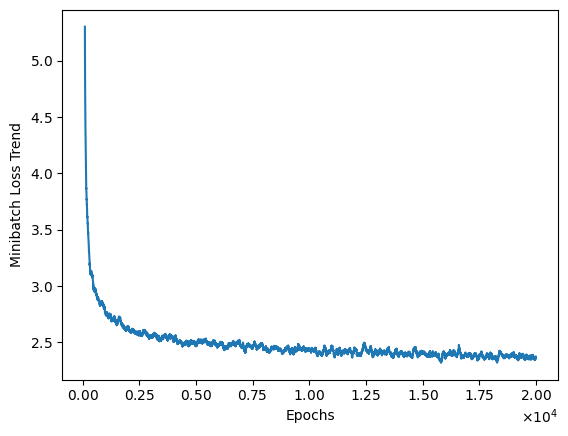

In [37]:
pd.Series(lossi[:])\
    .rolling(100).mean().dropna()\
    .plot(
        xlabel="Epochs",
        ylabel="Minibatch Loss Trend",
    ).ticklabel_format(
        axis='both', 
        style='sci',
        scilimits=(0,0),
        useMathText=True,
    )
plt.show()

In [38]:
names=[]
for _ in range(100):
    name="........"
    pred=28
    while pred != 0:
        model.train_mode(False)
        y_pred = model(np.array([stoi[letter] for letter in name][-8:]).reshape(1,-1)).softmax().data.reshape(27)
        pred = np.random.multinomial(1,y_pred).argmax()
        # pred = np.random.multinomial(1,[1/27 for i in range(27)]).argmax()
        pred_letter=itos[pred]
        name += str(pred_letter)
        model.train_mode(True)

    names.append(name[8:-1])
print(names)

['torinhag', 'aryina', 'arrar', 'caylr', 'koaree', 'zayrel', 'naudonah', 'khalaaha', 'avystr', 'afrela', 'qrahil', 'amemaa', 'omilyys', 'jaala', 'alan', 'jolmyle', 'carennyv', 'dsresoa', 'zecle', 'kanas', 'raryc', 'amwins', 'nailar', 'rhuix', 'brablens', 'lukin', 'elyohranutse', 'maerlae', 'prlot', 'tren', 'zaletha', 'sayva', 'aheerahur', 'navima', 'amurles', 'mavaii', 'hasamar', 'kaohanl', 'khral', 'xymaenaers', 'namirihi', 'koleld', 'arelyanisad', 'darara', 'emer', 'kallan', 'jarelia', 'yhosd', 'jaylun', 'davon', 'ekise', 'arraare', 'lurrii', 'makrara', 'amma', 'cunayaa', 'monnolat', 'nala', 'keady', 'horlen', 'jaria', 'allaner', 'kaldanhaa', 'hajann', 'ryilo', 'canlar', 'destair', 'kzejahh', 'zalaha', 'kentoky', 'hevaah', 'ralan', 'uuleni', 'elaana', 'jaannt', 'whymea', 'shorman', 'imetsa', 'aymal', 'dmal', 'rarkar', 'kermoe', 'nadlie', 'chanora', 'maysan', 'anseugm', 'amaxa', 'daraa', 'arinra', 'ayqtiia', 'leshrnl', 'toivore', 'kehrise', 'joniamy', 'narersr', 'kerrylel', 'cyrmen', 